# Conclusions
After about 15 articles, the likelyhood of an article being within the related articles gets lower and lower, meaning the gains of inspecting more articles for selection (or querying more articles than 30), is probably not worth the computational time.

In [ ]:
import os
import json
import pickle
import collections

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from valerie.utils import get_logger
from valerie.scoring import validate_predictions_phase2, compute_score_phase2

In [ ]:
def compute_score_phase2(labels, predictions):
    """
    predictions and labels are a dict
    check for duplicate relevant articles
    """
    n_class = collections.Counter([labels[o]["label"] for o in labels])
    scores = {"0": [], "1": [], "2": []}
    preds = []
    explanations = []
    if len(predictions) != len(labels):
        raise ValueError("prediction missing for some claims")
    # loop over predictions as the normalizing factor is n_class (# labels predicted)
    for claim_id in predictions:
        if len(predictions[claim_id]["explanation"]) > 1000:
            return {
                "score": 0.0,
                "explanation": "'N/S'",
                "error": "'MaxCharacterLimitError'",
                "predictions": "'N/A'",
            }
        pred = predictions[claim_id]["label"]
        preds.append(str(pred))
        label = labels[claim_id]["label"]
        if pred != label:
            scores[str(label)].append(0)
            continue
        rel_articles = list(predictions[claim_id]["related_articles"].values())
#         if len(rel_articles) > 2:
#             return {
#                 "score": 0.0,
#                 "explanation": "'N/S'",
#                 "error": "'MaxRelatedArticlesLimitError'",
#                 "predictions": "'N/A'",
#             }
        # remove any duplicate url links
        rel_articles = set(rel_articles)
        gt_rel_articles = list(labels[claim_id]["related_articles"].values())
        scores[str(label)].append(
            sum([int(a in gt_rel_articles) for a in rel_articles])
        )
        explanations.append(predictions[claim_id]["explanation"].replace("'", ""))

    for l in scores:
        if not scores[l]:  # if scores[l] is [], np.mean returns a NaN
            scores[l] = 0.0
        else:
            scores[l] = sum(scores[l]) / n_class[int(l)]

    return {
        "score": np.mean(list(scores.values())),
        "error": "'None'",
        "explanation": "'{}'".format("|".join(explanations)),
        "predictions": "'[{}]'".format(",".join(preds)),
    }

In [ ]:
def compute_responses_score(responses, num_to_keep):
    predictions = {}
    perfect_predictions = {}
    labels = {}

    for v in responses:
        claim = v["claim"]
        labels[claim.id] = claim.to_dict()
        predictions[claim.id] = {
            "label": claim.label,
            "related_articles": {
                i + 1: x
                for i, x in enumerate(
                    [hit["url"] for hit in v["res"]["hits"]["hits"][:num_to_keep]]
                )
            }
            if v["res"]
            else {},
            "explanation": "",
        }
        perfect_predictions[claim.id] = {
            "label": claim.label,
            "related_articles": {
                i + 1: x
                for i, x in enumerate(
                    [
                        hit["url"]
                        for hit in v["res"]["hits"]["hits"]
                        if hit["url"] in claim.related_articles.values()
                    ][:num_to_keep]
                )
            }
            if v["res"]
            else {},
            "explanation": "",
        }

#     validate_predictions_phase2(predictions)
    score = compute_score_phase2(labels, predictions)
#     validate_predictions_phase2(perfect_predictions)
    perfect_score = compute_score_phase2(labels, perfect_predictions)
    return {
        "perfect_rerank_score": perfect_score["score"],
        "perfect_rerank_error": perfect_score["error"],
        "api_score": score["score"],
        "api_error": score["error"],
    }

# Phase2 Train

In [4]:
with open("data/phase2-3/processed/responses.pkl", "rb") as fi:
    responses = pickle.load(fi)

In [5]:
len(responses)

13061

In [6]:
perfect_scores = []
scores = []
for i in tqdm(range(30)):
    _result = compute_responses_score(responses, i)
    perfect_scores.append(_result["perfect_rerank_score"])
    scores.append(_result["api_score"])

In [7]:
for i, (ps, s) in enumerate(zip(perfect_scores, scores)):
    print("{}\t{:.3f}\t{:.3f}".format(i, float(ps), float(s)))

0	0.000	0.000
1	0.620	0.335
2	0.914	0.488
3	1.038	0.586
4	1.095	0.656
5	1.120	0.712
6	1.131	0.758
7	1.136	0.795
8	1.139	0.826
9	1.141	0.859
10	1.142	0.884
11	1.143	0.907
12	1.143	0.930
13	1.143	0.950
14	1.143	0.969
15	1.143	0.989
16	1.143	1.005
17	1.143	1.022
18	1.143	1.038
19	1.143	1.053
20	1.143	1.066
21	1.143	1.078
22	1.143	1.090
23	1.143	1.101
24	1.143	1.111
25	1.143	1.119
26	1.143	1.128
27	1.143	1.134
28	1.143	1.139
29	1.143	1.142


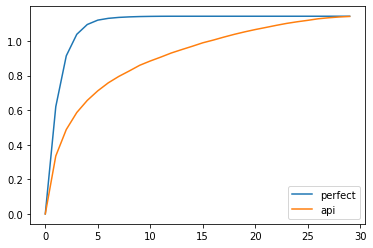

In [8]:
plt.plot(list(range(30)), perfect_scores, label="perfect")
plt.plot(list(range(30)), scores, label="api")
plt.legend()
plt.show()

# Phase2 Validation

In [10]:
with open("data/phase2-validation/processed/responses.pkl", "rb") as fi:
    responses = pickle.load(fi)

In [11]:
len(responses)

500

In [12]:
perfect_scores = []
scores = []
for i in tqdm(range(30)):
    _result = compute_responses_score(responses, i)
    perfect_scores.append(_result["perfect_rerank_score"])
    scores.append(_result["api_score"])

In [13]:
for i, (ps, s) in enumerate(zip(perfect_scores, scores)):
    print("{}\t{:.3f}\t{:.3f}".format(i, float(ps), float(s)))

0	0.000	0.000
1	0.719	0.415
2	1.156	0.662
3	1.363	0.820
4	1.469	0.909
5	1.530	0.977
6	1.567	1.033
7	1.598	1.090
8	1.611	1.141
9	1.622	1.205
10	1.624	1.251
11	1.624	1.282
12	1.624	1.308
13	1.624	1.331
14	1.624	1.351
15	1.624	1.386
16	1.624	1.404
17	1.624	1.428
18	1.624	1.454
19	1.624	1.470
20	1.624	1.494
21	1.624	1.500
22	1.624	1.519
23	1.624	1.534
24	1.624	1.545
25	1.624	1.556
26	1.624	1.561
27	1.624	1.577
28	1.624	1.598
29	1.624	1.611


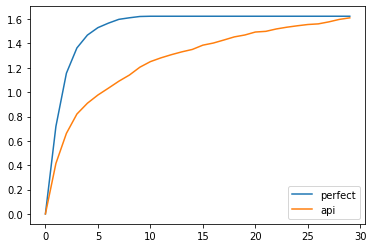

In [14]:
plt.plot(list(range(30)), perfect_scores, label="perfect")
plt.plot(list(range(30)), scores, label="api")
plt.legend()
plt.show()

# Phase2 Trial

In [15]:
with open("data/phase2-trial/processed/responses.pkl", "rb") as fi:
    responses = pickle.load(fi)

In [16]:
len(responses)

100

In [17]:
perfect_scores = []
scores = []
for i in tqdm(range(30)):
    _result = compute_responses_score(responses, i)
    perfect_scores.append(_result["perfect_rerank_score"])
    scores.append(_result["api_score"])

In [18]:
for i, (ps, s) in enumerate(zip(perfect_scores, scores)):
    print("{}\t{:.3f}\t{:.3f}".format(i, float(ps), float(s)))

0	0.000	0.000
1	0.763	0.402
2	1.179	0.601
3	1.401	0.779
4	1.482	0.872
5	1.522	1.026
6	1.522	1.094
7	1.522	1.199
8	1.522	1.225
9	1.522	1.233
10	1.522	1.274
11	1.522	1.314
12	1.522	1.355
13	1.522	1.379
14	1.522	1.388
15	1.522	1.396
16	1.522	1.405
17	1.522	1.430
18	1.522	1.448
19	1.522	1.448
20	1.522	1.448
21	1.522	1.456
22	1.522	1.456
23	1.522	1.456
24	1.522	1.465
25	1.522	1.465
26	1.522	1.497
27	1.522	1.497
28	1.522	1.497
29	1.522	1.513


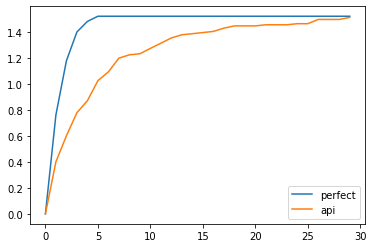

In [19]:
plt.plot(list(range(30)), perfect_scores, label="perfect")
plt.plot(list(range(30)), scores, label="api")
plt.legend()
plt.show()